## 신용카드 사용자 연체 예측 AI 경진대회

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 변수
 - gender: 성별
 - car: 차량 소유 여부
 - reality : 부동산 소유 여부
 - child num: 자녀 수
 - income_total : 연간 소득
 - income_type : 소득 분류=> ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
 - edu_type : 교육 수준 => ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
 - family_type: 결혼 여부 => ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
 - house_type: 생활방식 => ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']
 - day_birth: 출생일 =>-1은 데이터 수집일 하루 전 출생,데이터수집당시 0으로부터 역으로 셈(하루단위)
 - day_employed: 업무 시작일. 하루단위로 계산. 양수는 고용x
 - flag_mobil: 휴대폰 소유 여부
 - work_phone: 업무용 전화 소유 여부
 - phone: 전화 소유 여부
 - email: 이메일 소유 여부
 - occyp_type: 직업 유형
 - family_size: 가족 규모
 - begin_month: 신용카드 발급월

종속변수 (credit) : 사용자의 신용카드 대금 연체를 기준으로 한 신용도. 낮을수록 높은 신용의 신용카드 사용자를 의미

In [64]:
pip install tqdm

In [65]:
# tabnet

!pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'

!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

  Cloning https://github.com/dreamquark-ai/tabnet.git (to revision develop) to /tmp/pip-install-gap4qwhz/pytorch-tabnet
  Running command git clone -q https://github.com/dreamquark-ai/tabnet.git /tmp/pip-install-gap4qwhz/pytorch-tabnet
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pytorch-tabnet: filename=pytorch_tabnet-3.1.1-cp37-none-any.whl size=39326 sha256=dbf370437df193bcfe8cb3ee932ec034b2624d8b3cea2c676b2862d1c401b1dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-3mdmcwso/wheels/a5/fe/e1/d7be493728d1fb7284583f5449d4cad80139ee994ef420f522
Successfully built pytorch-tabnet
  Found existing installation: pytorch-tabnet 3.1.1
    Uninstalling pytorch-tabnet-3.1.1:
      Successfully uninstalled pytorch-tabnet-3.1.1


In [66]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import torch
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import KFold, StratifiedKFold,cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import random
from keras.wrappers.scikit_learn import KerasClassifier
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 50)

In [67]:
train=pd.read_csv('/content/drive/MyDrive/데이터/신용카드 연체예측/train.csv')
test=pd.read_csv('/content/drive/MyDrive/데이터/신용카드 연체예측/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/데이터/신용카드 연체예측/sample_submission.csv')
df_train=train.copy()
df_test=test.copy()

In [68]:
print(train.shape,test.shape)

(26457, 20) (10000, 19)


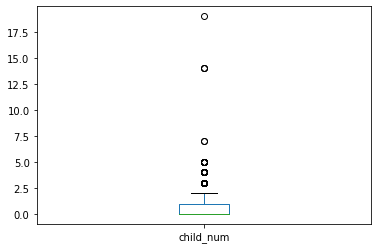

In [69]:
#추가적으로 child_num이 outlier를 확인하고 처리했습니다.
df_train['child_num'].plot(kind='box')

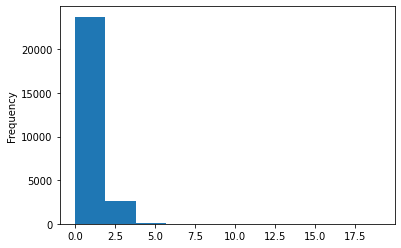

In [70]:
df_train['child_num'].plot(kind='hist')

# 전처리

## 각종 변수 처리

In [71]:
# DAYS_BIRTH ,begin_month 양수로 , DAYS_EMPLOYED는 regression후에 양수로 바꿔줍니다.

df_train['DAYS_BIRTH'] = (df_train['DAYS_BIRTH'] * (-1)) / 365
df_test['DAYS_BIRTH'] = (df_test['DAYS_BIRTH'] * (-1)) / 365

df_train['begin_month'] = df_train['begin_month'] * (-1)
df_test['begin_month'] = df_test['begin_month'] * (-1)

df_train.loc[df_train['child_num'] >= 2,'child_num'] = 2
df_test.loc[df_test['child_num'] >= 2,'child_num'] = 2

In [72]:
# income_total을 7개의 계층으로 나눠줍니다.

df_train['income_total'] = df_train['income_total'].astype(object)
df_train['income_total'] = df_train['income_total']/10000 
count, bin_dividers =np.histogram(df_train['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
df_train['income_total']=pd.cut(x=df_train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

df_test['income_total'] = df_test['income_total'].astype(object)
df_test['income_total'] = df_test['income_total']/10000 
count, bin_dividers =np.histogram(df_test['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
df_test['income_total']=pd.cut(x=df_test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)



In [73]:
#DAYS_EMPLOYED : 365243 -> 0

df_train.loc[df_train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED'] = 0
df_test.loc[df_test['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED'] = 0

## 결측치 처리(occyp_type)

### 결측치 중 대체 가능한 것 대체하기

In [74]:
#train data
train_non_occyp=df_train.loc[df_train['occyp_type'].isnull()]#직업유형이 없는 사람
train_occyp=df_train.dropna()#직업유형이 있는 사람(결측치 제거)

print(train_occyp.shape,train_non_occyp.shape)
train_non_occyp.loc[train_non_occyp['DAYS_EMPLOYED']>=0, 'occyp_type']= 'Inoccupation'
#고용되지 않은 사람은 inocc로 처리.

(18286, 20) (8171, 20)


In [75]:
#test data
test_non_occyp=df_test.loc[df_test['occyp_type'].isnull()]#직업유형이 없는 사람
test_occyp=df_test.dropna()#직업유형이 있는 사람(결측치 제거)
print(test_occyp.shape,test_non_occyp.shape)
test_non_occyp.loc[test_non_occyp['DAYS_EMPLOYED']>=0, 'occyp_type']= 'Inoccupation'
#고용되지 않은 사람은 inocc로 처리.

(6848, 19) (3152, 19)


### 남은 결측치 처리(regression)

In [76]:
# 결측치를 대체한 train, test값을 다시 하나로 합친다.
train_data=pd.concat([train_occyp,train_non_occyp])
train_data =train_data.sort_values(by='index' ,ascending=True)

test_data=pd.concat([test_occyp,test_non_occyp])
test_data =test_data.sort_values(by='index' ,ascending=True)

print(train_data.shape,test_data.shape)

(26457, 20) (10000, 19)


In [77]:
#명목형 변수 라벨화 (원핫 인코딩도 해볼 것)
label_encoder=preprocessing.LabelEncoder()
#############################################################
train_data['gender'] = train_data['gender'].replace(['F','M'],[0,1])
test_data['gender'] = test_data['gender'].replace(['F','M'],[0,1])
###############################################################
train_data['car'] = train_data['car'].replace(['N','Y'],[0,1])
test_data['car'] = test_data['car'].replace(['N','Y'],[0,1])
###############################################################
train_data['reality'] = train_data['reality'].replace(['N','Y'],[0,1])
test_data['reality'] = test_data['reality'].replace(['N','Y'],[0,1])
###############################################################
train_data['income_type']=label_encoder.fit_transform(train_data['income_type'])
test_data['income_type']=label_encoder.fit_transform(test_data['income_type'])
# #################################################################
train_data['edu_type']=label_encoder.fit_transform(train_data['edu_type'])
test_data['edu_type']=label_encoder.fit_transform(test_data['edu_type'])
########################################################################
train_data['family_type']=label_encoder.fit_transform(train_data['family_type'])
test_data['family_type']=label_encoder.fit_transform(test_data['family_type'])
########################################################################
train_data['house_type']=label_encoder.fit_transform(train_data['house_type'])
test_data['house_type']=label_encoder.fit_transform(test_data['house_type'])
########################################################################
train_data['income_total']=label_encoder.fit_transform(train_data['income_total'])
test_data['income_total']=label_encoder.fit_transform(test_data['income_total'])
#######################################################################

#occyp_type은 뒤에서 regression 후에 label_encoder


In [78]:
#다시 남은 결측치를 처리하기 위해 데이터를 나눈다.(train,test)

train_null_data=train_data.loc[train_data['occyp_type'].isnull()]
train_fill_data=train_data.dropna() #결측치 제거한 데이터

print("train :",train_fill_data.shape,train_null_data.shape)

test_null_data=test_data.loc[test_data['occyp_type'].isnull()]
test_fill_data=test_data.dropna() #결측치 제거한 데이터

print("test :",test_fill_data.shape,test_null_data.shape)

train : (22724, 20) (3733, 20)
test : (8545, 19) (1455, 19)


In [79]:
train_fill_data['occyp_type_l']=label_encoder.fit_transform(train_fill_data['occyp_type'])
#결측치 없는 데이터 중 occyp_type를 라벨링한 변수를 추가(라벨링과 원래값 비교를 위해)

train_le_lst = list(label_encoder.classes_)
print(train_le_lst)

['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', 'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Inoccupation', 'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff']


In [80]:
test_fill_data['occyp_type_l']=label_encoder.fit_transform(test_fill_data['occyp_type'])

test_le_lst = list(label_encoder.classes_)
print(test_le_lst)

['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', 'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Inoccupation', 'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff']


In [81]:
#train data 선형회귀
train_lin_reg = linear_model.LinearRegression()
x=train_fill_data[train_fill_data.columns.drop(['index','occyp_type','credit',
                                   'occyp_type_l'])]
#employeed(0,1)을 넣지 않고 days_employed에서 양수값을 0으로 처리한 상태에서 재시도
#라벨링한 occyp_type_l는 종속변수로 사용
y=train_fill_data['occyp_type_l']#라벨링 상태
train_lin_reg_model = train_lin_reg.fit(x, y)

x_test=train_null_data[train_null_data.columns.drop(['index','occyp_type','credit'])]
y_test=train_null_data['occyp_type']
y_test=train_lin_reg.predict(x_test) #결측치가 있는 데이터에 대입

In [82]:
train_null_data['occyp_type']=y_test

In [83]:
train_null_data['occyp_type']=np.round(train_null_data['occyp_type'],0)#반올림

#라벨링->원래값
for i in range(len(train_le_lst)):
    train_null_data.loc[train_null_data['occyp_type']== i,'occyp_type']=train_le_lst[i]
    
train_fill_data=train_fill_data.drop('occyp_type_l',axis=1)
train_data=pd.concat([train_null_data,train_fill_data]).sort_values(by='index')

In [84]:
train_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,38.079452,-4709,1,0,0,0,Inoccupation,2.0,6.0,1.0
1,1,0,0,1,1,0,0,4,0,1,31.178082,-1540,1,0,0,1,Laborers,3.0,5.0,1.0
2,2,1,1,1,0,1,4,1,1,1,52.293151,-4434,1,0,1,0,Managers,2.0,22.0,2.0
3,3,0,0,1,0,0,0,4,1,1,41.336986,-2092,1,0,1,0,Sales staff,2.0,37.0,0.0
4,4,0,1,1,0,0,2,1,1,1,41.197260,-2105,1,0,0,0,Managers,2.0,26.0,2.0


In [85]:
#test data 선형회귀
test_lin_reg = linear_model.LinearRegression()
x=test_fill_data[test_fill_data.columns.drop(['index','occyp_type',
                                   'occyp_type_l'])]
#employeed(0,1)을 넣지 않고 days_employed에서 양수값을 0으로 처리한 상태에서 재시도
#라벨링한 occyp_type_l는 종속변수로 사용
y=test_fill_data['occyp_type_l']#라벨링 상태
test_lin_reg_model = test_lin_reg.fit(x, y)

x_test=test_null_data[test_null_data.columns.drop(['index','occyp_type'])]
y_test=test_null_data['occyp_type']
y_test=test_lin_reg.predict(x_test)#결측치가 있는 데이터에 대입

In [86]:
test_null_data['occyp_type']=y_test

In [87]:
test_null_data['occyp_type']=np.round(test_null_data['occyp_type'],0)#반올림

#라벨링->원래값
for i in range(len(test_le_lst)):
    test_null_data.loc[test_null_data['occyp_type']== i,'occyp_type']=test_le_lst[i]
    
test_fill_data=test_fill_data.drop('occyp_type_l',axis=1)
test_data=pd.concat([test_null_data,test_fill_data]).sort_values(by='index',ascending=True)

In [88]:
# occyp_type 을 다시 label encoder
train_data['occyp_type']=label_encoder.fit_transform(train_data['occyp_type'])

test_data['occyp_type']=label_encoder.fit_transform(test_data['occyp_type'])

In [89]:
train_data['DAYS_EMPLOYED'] = train_data ['DAYS_EMPLOYED'] * (-1) / 365
test_data['DAYS_EMPLOYED'] = test_data ['DAYS_EMPLOYED'] * (-1) / 365

In [90]:
train_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,38.079452,12.901370,1,0,0,0,8,2.0,6.0,1.0
1,1,0,0,1,1,0,0,4,0,1,31.178082,4.219178,1,0,0,1,9,3.0,5.0,1.0
2,2,1,1,1,0,1,4,1,1,1,52.293151,12.147945,1,0,1,0,11,2.0,22.0,2.0
3,3,0,0,1,0,0,0,4,1,1,41.336986,5.731507,1,0,1,0,15,2.0,37.0,0.0
4,4,0,1,1,0,0,2,1,1,1,41.197260,5.767123,1,0,0,0,11,2.0,26.0,2.0


In [91]:
test_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,1,1,0,0,0,1,4,0,1,60.246575,0.000000,1,0,1,0,8,2.0,60.0
1,26458,0,0,1,0,0,2,1,1,1,51.956164,23.756164,1,0,1,0,3,2.0,36.0
2,26459,0,0,1,0,0,4,4,1,1,43.526027,0.594521,1,1,1,0,9,2.0,40.0
3,26460,1,1,0,0,0,0,4,1,1,52.794521,6.934247,1,1,0,0,4,2.0,41.0
4,26461,0,1,1,0,0,2,1,1,1,48.827397,25.712329,1,1,0,0,11,2.0,8.0


##########################################

전처리 끝

In [92]:
train=train_data[:len(train_data)-10000]
test=train_data[len(train_data)-10000:]

In [93]:
train_x = train.drop(['credit','index'],axis=1)
train_y= train[['credit']]
test_x = test.drop(['index'],axis=1)

np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index

In [94]:

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)

        try:
            test_X[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)
print(categorical_columns,categorical_dims)
print(train_x.shape,train_y.shape,test_x.shape)

gender 2
Column gender does not exist in test set
car 2
Column car does not exist in test set
reality 2
Column reality does not exist in test set
child_num 3
Column child_num does not exist in test set
income_total 6
Column income_total does not exist in test set
income_type 5
Column income_type does not exist in test set
edu_type 5
Column edu_type does not exist in test set
family_type 5
Column family_type does not exist in test set
house_type 6
Column house_type does not exist in test set
FLAG_MOBIL 1
Column FLAG_MOBIL does not exist in test set
work_phone 2
Column work_phone does not exist in test set
phone 2
Column phone does not exist in test set
email 2
Column email does not exist in test set
occyp_type 19
Column occyp_type does not exist in test set
family_size 9
Column family_size does not exist in test set
begin_month 61
Column begin_month does not exist in test set

['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type

In [95]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,0,0,0,0,0,0,1,1,2,38.079452,12.901370,0,0,0,0,8,1,6
1,0,0,1,1,0,0,4,0,1,31.178082,4.219178,0,0,0,1,9,2,5
2,1,1,1,0,1,4,1,1,1,52.293151,12.147945,0,0,1,0,11,1,22
3,0,0,1,0,0,0,4,1,1,41.336986,5.731507,0,0,1,0,15,1,37
4,0,1,1,0,0,2,1,1,1,41.197260,5.767123,0,0,0,0,11,1,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16452,0,1,0,1,0,4,4,1,1,41.265753,5.517808,0,1,0,0,8,2,3
16453,1,1,1,0,0,4,4,1,1,27.273973,5.578082,0,0,0,0,9,1,8
16454,0,1,0,0,1,4,1,1,0,35.791781,6.263014,0,1,0,0,12,1,33
16455,0,1,1,0,0,1,4,1,1,67.901370,0.000000,0,0,0,0,8,1,54


In [96]:
features = [ col for col in train_x.columns] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

print(features)
print(cat_idxs)
print(cat_dims)

['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17]
[2, 2, 2, 3, 6, 5, 5, 5, 6, 1, 2, 2, 2, 19, 9, 61]


In [97]:
X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x[features].values


## 모델링

In [99]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', 
                                lambda_sparse=0, 
                       
                      )
print(clf)

Device used : cpu
TabNetMultiTaskClassifier(n_d=8, n_a=8, n_steps=1, gamma=1.3, cat_idxs=[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17], cat_dims=[2, 2, 2, 3, 6, 5, 5, 5, 6, 1, 2, 2, 2, 19, 9, 61], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=None, output_dim=None, device_name='auto')


In [100]:
#tabnet

max_epochs = 1000
clf.fit(
    X_train=X_train, y_train=y_train,
    max_epochs=max_epochs ,
    patience=50,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False
)

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.02384 |  0:00:01s
epoch 1  | loss: 0.88854 |  0:00:02s
epoch 2  | loss: 0.87399 |  0:00:03s
epoch 3  | loss: 0.86289 |  0:00:04s
epoch 4  | loss: 0.84758 |  0:00:05s
epoch 5  | loss: 0.83148 |  0:00:06s
epoch 6  | loss: 0.81754 |  0:00:06s
epoch 7  | loss: 0.80906 |  0:00:07s
epoch 8  | loss: 0.80352 |  0:00:08s
epoch 9  | loss: 0.80176 |  0:00:09s
epoch 10 | loss: 0.79878 |  0:00:10s
epoch 11 | loss: 0.79607 |  0:00:11s
epoch 12 | loss: 0.79273 |  0:00:12s
epoch 13 | loss: 0.79129 |  0:00:13s
epoch 14 | loss: 0.7901  |  0:00:14s
epoch 15 | loss: 0.78657 |  0:00:15s
epoch 16 | loss: 0.78406 |  0:00:16s
epoch 17 | loss: 0.78333 |  0:00:17s
epoch 18 | loss: 0.77983 |  0:00:18s
epoch 19 | loss: 0.77809 |  0:00:19s
epoch 20 | loss: 0.77642 |  0:00:20s
epoch 21 | loss: 0.77526 |  0:00:21s
epoch 22 | loss: 0.7755  |  0:00:22s
epoch 23 | loss: 0.77093 |  0:00:23s
epoch 24 | loss: 0.76927 |  0:00:24s
ep

epoch 999| loss: 0.62224 |  0:18:09s

epoch 999| loss: 0.60595 |  0:15:59s

파라미터 튜닝을 해봤으면 좋을 것 같습니다

In [ ]:
# MLP

from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dropout,BatchNormalization

label_encoder=preprocessing.LabelEncoder()

train_x = train_data.drop(['credit','index'],axis=1)
train_y = train_data[['credit']]
train_y_encoded = label_encoder.fit_transform(train_y)


def MLP_model():
  n_cols= train_x.shape[1]

  model = Sequential()
  model.add(BatchNormalization())
  model.add(Dense(64,activation = 'relu', input_shape = (n_cols,)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(3, activation='softmax'))


  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model

  estimator = KerasClassifier(build_fn = MLP_model, epochs = 100, batch_size = 100, verbose = 1)

#교차 검증 
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
results = cross_val_score(estimator, train_x, train_y_encoded, cv = kfold, scoring='neg_log_loss')
print(results)
print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))